In [1]:
# Configuration OpenMP
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

# Imports des modules locaux
from data_loading import *
from models import *
from training import *
from visualization import *
from evaluation import *

print("✓ Modules rechargés avec succès")


✓ Modules rechargés avec succès


### Env configuration

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# Data path configuration
project_root = Path(os.getcwd()).parent.parent  # go back from modular -> NFTM_for_Physic -> NFTM
data_dir = project_root / "Data"
print(f"Data directory: {data_dir}")

models_dir = project_root /"NFTM_for_Physic"/ "saved_models"

# Check file existence
files_burger = {
    0.001: data_dir / "burgers1D_training_data_Nu0.001.npz",
    0.01:  data_dir / "burgers1D_training_data_Nu0.01.npz",
    0.1:   data_dir / "burgers1D_training_data_Nu0.1.npz",
    0.5:   data_dir / "burgers1D_training_data_Nu0.5.npz",
}

print("\nAvailable data files:")
for nu, filepath in files_burger.items():
    exists = "✓" if filepath.exists() else "✗"
    print(f"  {exists} Nu={nu}: {filepath.name}")

Device used: cuda
Data directory: c:\Dev\CentralSupelec\BDRP\NFTM\Data

Available data files:
  ✓ Nu=0.001: burgers1D_training_data_Nu0.001.npz
  ✓ Nu=0.01: burgers1D_training_data_Nu0.01.npz
  ✓ Nu=0.1: burgers1D_training_data_Nu0.1.npz
  ✓ Nu=0.5: burgers1D_training_data_Nu0.5.npz


### Dataset Configuration and Loading

In [3]:
# ========== DATASET CONFIGURATION ==========
# Change this parameter to switch between datasets:
# - "simple": Uses BurgersDatasetSimple (one trajectory per viscosity from Data/ folder)
# - "generated": Uses BurgersViscosityDataset (multiple samples from generated_1d_burgers/ folder)

DATASET_TYPE = "generated"  # Change to "generated" to use the other dataset

batch_size = 4
history_len = 3  # Only used for "generated" dataset

# ========== DATASET LOADING ==========
if DATASET_TYPE == "simple":
    print("📁 Using BurgersDatasetSimple with Data/ folder files")
    train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
    test_loader = None  # No test split for simple dataset
    
elif DATASET_TYPE == "generated":
    print("📁 Using BurgersViscosityDataset with separate train/test folders")
    # Paths to your separate train and test folders
    train_data_dir = project_root / "NFTM_for_Physic" / "generated_1d_burgers" / "train"
    test_data_dir = project_root / "NFTM_for_Physic" / "generated_1d_burgers" / "test"
    
    # Check if both directories exist
    if not train_data_dir.exists():
        print(f"❌ Training data directory not found: {train_data_dir}")
        print("Creating a fallback to simple dataset...")
        DATASET_TYPE = "simple"
        train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
        test_loader = None
    elif not test_data_dir.exists():
        print(f"❌ Test data directory not found: {test_data_dir}")
        print("Creating a fallback to simple dataset...")
        DATASET_TYPE = "simple"
        train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
        test_loader = None
    else:
        try:
            train_loader, test_loader = create_generated_dataloaders_from_folders(
                train_dir=str(train_data_dir),
                test_dir=str(test_data_dir),
                history_len=history_len,
                batch_size=batch_size
            )
            print(f"✓ Training dataset loaded from: {train_data_dir}")
            print(f"✓ Test dataset loaded from: {test_data_dir}")
        except Exception as e:
            print(f"❌ Error loading generated datasets: {e}")
            print("Falling back to simple dataset...")
            DATASET_TYPE = "simple"
            train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
            test_loader = None

else:
    raise ValueError(f"Unknown dataset type: {DATASET_TYPE}. Use 'simple' or 'generated'")

📁 Using BurgersViscosityDataset with separate train/test folders
✓ Training dataset loaded from: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers\train
✓ Test dataset loaded from: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers\test
✓ Training dataset loaded from: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers\train
✓ Test dataset loaded from: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers\test


In [4]:
# ===== Validate npz files in generated folders when using DATASET_TYPE == 'generated' =====
if DATASET_TYPE == 'generated':
    print('\nRunning validate_npz_files for generated dataset')
    generated_root = project_root / 'NFTM_for_Physic' / 'generated_1d_burgers'
    train_dir = generated_root / 'train'
    test_dir = generated_root / 'test'

    def _print_validation(root_dir):
        print('\nValidating', root_dir)
        good, bad = validate_npz_files(str(root_dir), max_examples=None)
        print(f"  -> {len(good)} good files, {len(bad)} bad files")
        if bad:
            print('  Corrupted files (first 10 shown):')
            for b in bad[:10]:
                print('   -', b['path'])
        else:
            print('  No corrupted files detected.')
        # show unique nu values from a few good files
        nus = set()
        for g in good[:50]:
            if g['nu'] is not None:
                nus.add(round(float(g['nu']), 12))
        print('  nu values (from inspected files):', sorted(list(nus)))

    if train_dir.exists():
        _print_validation(train_dir)
    else:
        print('  Train directory not found:', train_dir)

    if test_dir.exists():
        _print_validation(test_dir)
    else:
        print('  Test directory not found:', test_dir)



Running validate_npz_files for generated dataset

Validating c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers\train
  -> 600 good files, 0 bad files
  No corrupted files detected.
  nu values (from inspected files): [0.10000000149]

Validating c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers\test
  -> 600 good files, 0 bad files
  No corrupted files detected.
  nu values (from inspected files): [0.10000000149]

Validating c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers\test
  -> 2989 good files, 0 bad files
  No corrupted files detected.
  nu values (from inspected files): [0.009999999776, 0.026896551251, 0.043793104589, 0.060689654201, 0.077586203814, 0.094482757151, 0.111379310489, 0.128275856376, 0.145172417164, 0.162068963051, 0.178965523839, 0.195862069726, 0.212758615613, 0.229655176401, 0.246551722288, 0.263448268175, 0.280344814062, 0.297241389751, 0.314137935638, 0.331034481525, 0.347931027412, 0.364827573299, 0.381

Sample 471 | nu=0.1000
 initial_field: torch.Size([128])
 trajectory   : torch.Size([256, 128])


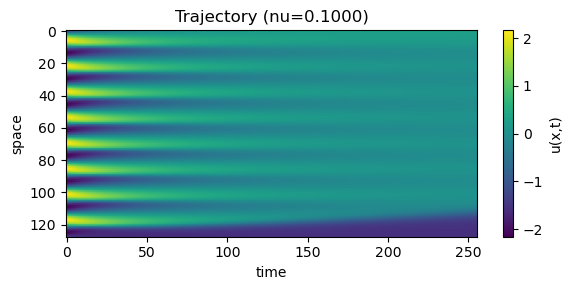

In [5]:
if DATASET_TYPE == "simple":
    # For simple dataset, show sample from the raw dataset
    dataset = train_loader.dataset
    idx = np.random.randint(0, len(dataset))
    show_random_sample(dataset, idx)
elif DATASET_TYPE == "generated":
    # For generated dataset, show sample from the training set
    dataset = train_loader.dataset
    if hasattr(dataset, 'dataset'):  # Handle random_split wrapper
        dataset = dataset.dataset
    idx = np.random.randint(0, len(dataset))
    show_random_sample(dataset, idx)

### Load model

In [6]:
# Model configuration
patch_radius = 1
patch_size = 2 * patch_radius + 1
chunk_size = 5

LOAD_MODEL_NAME = None

# --- CNN Model --- #
# model = CNNControllerPatch(patch_size=patch_size)

# --- RNN Model  --- #
# model = RNNControllerPatch(patch_size=patch_size)

# --- Transformer --- #
# model = TransformerController(patch_size=patch_size, hidden_size=64)

# --- CNN Model with space-time convolution --- #
# model = CNNSpaceTimeController(
#     patch_size=patch_size,
#     hidden_channels=64,
#     kernel_t=3,   # <=  chunk_size, sinon dim temps du kernel sera plus grande que L
#     kernel_x=3,
# ).to(device)

# model = SingleChannelSpaceTimeCNN(
#     patch_size=patch_size,
#     history_len=chunk_size,
# ).to(device)

# --- Load a saved model # 
LOAD_MODEL_NAME = "transformers.pth"  # Set to filename like "my_model.pth" to load a model


if LOAD_MODEL_NAME is not None:
    print(f"📥 Loading model from: {LOAD_MODEL_NAME}")
    model = torch.load(models_dir / LOAD_MODEL_NAME, map_location=device, weights_only=False)
    print(f"✓ Model loaded successfully")

model = model.to(device)

print(f"Model information:")
print(f"  - Patch radius: {patch_radius}")
print(f"  - Patch size: {patch_size}")
print(f"  - Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

📥 Loading model from: transformers.pth
✓ Model loaded successfully
Model information:
  - Patch radius: 1
  - Patch size: 3
  - Number of parameters: 8770

Model architecture:
TransformerController(
  (embed): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (attn): Linear(in_features=64, out_features=1, bias=True)
  (fc_out): Sequential(
    (0): ReLU()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Model training

In [7]:
num_epochs = 10

print(f"🚀 Starting training for {num_epochs} epochs with {DATASET_TYPE} dataset...")
print("=" * 60)

# Select appropriate training function based on model type
print(f"🚀 Starting training for {num_epochs} epochs with {DATASET_TYPE} dataset...")
print("=" * 60)

train_losses, training_mode = train_model_auto(
    model=model,
    dataloader=train_loader,
    device=device,
    patch_radius=patch_radius,
    num_epochs=num_epochs,
    chunk_size=chunk_size,   # utilisé seulement pour les modèles séquentiels
)

print(f"\n Training completed!")
print(f" Dataset used : {DATASET_TYPE}")
print(f" Model        : {model.__class__.__name__}")
print(f" Mode         : {training_mode}")
print(f" Final loss   : {train_losses[-1]:.6f}")

🚀 Starting training for 10 epochs with generated dataset...
🚀 Starting training for 10 epochs with generated dataset...


KeyboardInterrupt: 

### Loss funciton

In [ ]:
plot_losses(train_losses)

print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1])/train_losses[0]*100):.2f}%")

NameError: name 'train_losses' is not defined

## Visualization

🔍 Generating predictions using test data...
Loader nu values: [0.009999999776482582, 0.026896551251411438, 0.04379310458898544, 0.06068965420126915, 0.07758620381355286, 0.09448275715112686, 0.11137931048870087, 0.12827585637569427, 0.14517241716384888, 0.16206896305084229, 0.1789655238389969, 0.1958620697259903, 0.2127586156129837, 0.2296551764011383, 0.2465517222881317, 0.2634482681751251, 0.28034481406211853, 0.2972413897514343, 0.31413793563842773, 0.33103448152542114, 0.34793102741241455, 0.36482757329940796, 0.38172414898872375, 0.39862069487571716, 0.41551724076271057, 0.432413786649704, 0.4493103325366974, 0.4662069082260132, 0.4831034541130066, 0.5]
Generating predictions for nu = 0.5000
True trajectory shape: torch.Size([256, 128])
Model type: TransformerController
  step 0/251
  step 10/251
  step 20/251
  step 30/251
  step 40/251
  step 50/251
  step 60/251
  step 70/251
  step 80/251
  step 90/251
  step 100/251
  step 110/251
  step 120/251
  step 130/251
  step 140/251


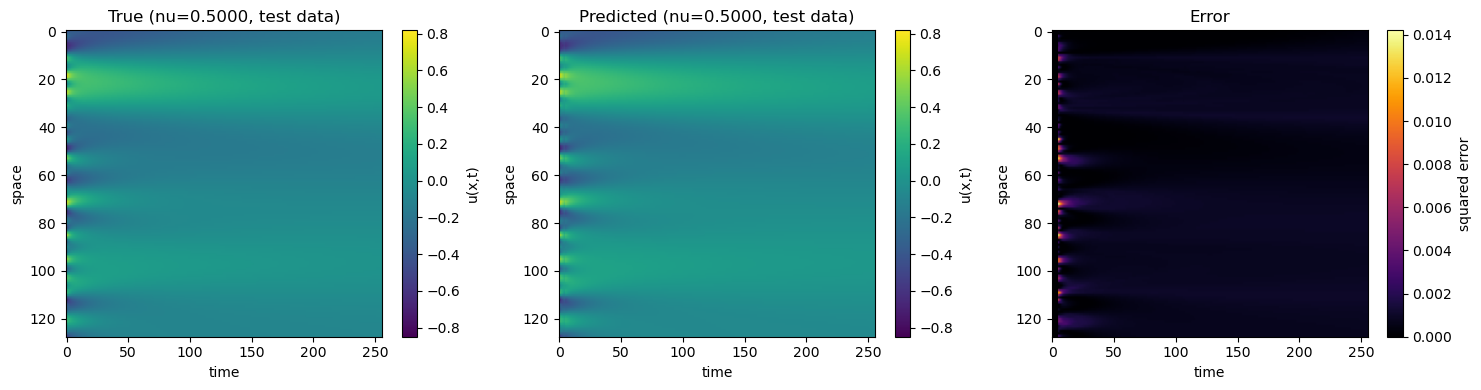

In [13]:
# Generate predictions for visualization
# Use test_loader if available, otherwise fall back to train_loader
PLOT_NU = None  # Set to None to automatically pick the first sample in eval_loader

eval_loader = test_loader if test_loader is not None else train_loader
loader_type = "test" if test_loader is not None else "train"

print(f"🔍 Generating predictions using {loader_type} data...")

# show loader contents if available
try:
    print("Loader nu values:", get_loader_nu_values(eval_loader))
except Exception as e:
    print("Could not enumerate loader nus:", e)

true_traj, pred_traj, nu_value = generate_model_predictions(
    model, 
    eval_loader, 
    device, 
    patch_radius, 
    verbose=True, 
    chunk_size=chunk_size,
    nu_target=PLOT_NU,
    list_nus=False,
    fallback_to_first=True,
)

# Visualize trajectories
plot_trajectories(true_traj, pred_traj, title_suffix=f" (nu={nu_value:.4f}, {loader_type} data)")

## Evaluation

📊 Evaluating model performance on test data...
Evaluation metrics:
  - PSNR: 31.594 dB
  - SSIM: 0.751
  - MSE: 0.000693
  - R²: 0.9500
Evaluation metrics:
  - PSNR: 31.594 dB
  - SSIM: 0.751
  - MSE: 0.000693
  - R²: 0.9500


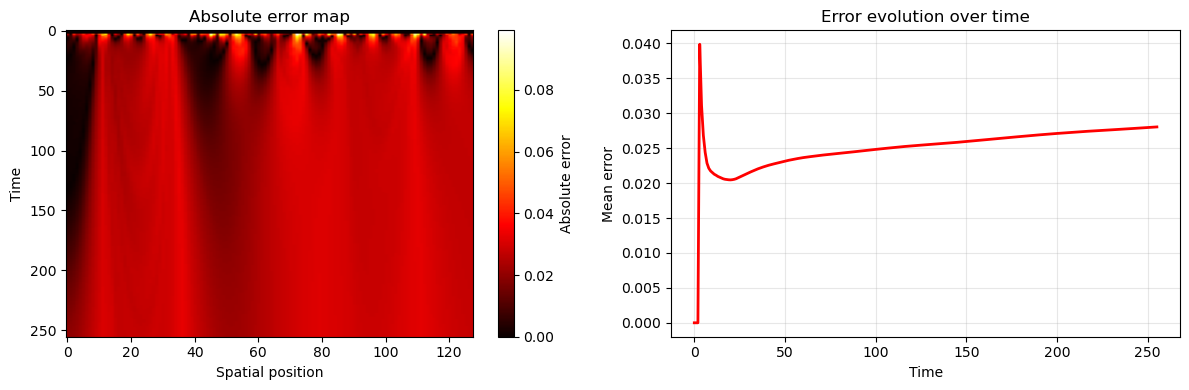

In [11]:
# Complete evaluation with dedicated function
# Use test_loader if available, otherwise fall back to train_loader
eval_loader = test_loader if test_loader is not None else train_loader
loader_type = "test" if test_loader is not None else "train"

print(f"📊 Evaluating model performance on {loader_type} data...")

evaluation_results = evaluate_model_on_sample(
    model, 
    eval_loader, 
    device, 
    patch_radius, 
    max_val=1.0, 
    val_range=1.0
)

# Display results with dedicated function
true_traj, pred_traj = display_evaluation_results(evaluation_results, show_plots=True)

## Mean Absolute Error (MAE) Formula

The Mean Absolute Error at time $t$ is defined as:

$$E(t) = \frac{1}{N} \sum_{x=1}^{N} |u_{\text{true}}(t, x) - u_{\text{pred}}(t, x)|$$

**Where:**
- $N$ is the number of spatial points
- $u_{\text{true}}(t, x)$ is the true solution at time $t$ and position $x$
- $u_{\text{pred}}(t, x)$ is the predicted solution at time $t$ and position $x$
- $| \cdot |$ denotes the absolute value

---

This formula calculates the average absolute difference between the true and predicted solutions across all spatial points at a given time step, providing a measure of prediction accuracy.

In [12]:
if test_loader is not None:
    mean_error_per_time = error_evolution_on_loader(
        model,
        test_loader,
        device,
        patch_radius=patch_radius,
        chunk_size=chunk_size,
        show_plot=True,   # met à False si tu veux juste les valeurs
    )
    print(f"Mean error_per_time shape: {mean_error_per_time.shape}")
else:
    print("No test loader available; skipping test set evaluation.")

KeyboardInterrupt: 

## Field for CNN
### conv1-field
How the model read the past values of u(t,f)

### conv1-nu
How the viscosity influence the local prediction

### conv2-field
How the second layer combine modification ectract with conv1 for the output

### filter 0
Individual kernel

In [ ]:
# conv1 : vue sur le champ (canal "field")
plot_space_time_kernel(model, layer_name="conv1", channel_type="field", out_channel=None)

# conv1 : même chose mais filtre 0 (c’est le seul, mais ça marche)
plot_space_time_kernel(model, layer_name="conv1", channel_type="field", out_channel=0)

# si tu veux voir l’impact de nu sur cette même couche
plot_space_time_kernel(model, layer_name="conv1", channel_type="nu", out_channel=None)

# tu peux aussi jeter un œil aux kernels de conv2 (une seule entrée, donc pas de 'nu')
plot_space_time_kernel(model, layer_name="conv2", channel_type="field", out_channel=None)


plot_space_time_kernel: le modèle n'a pas de couche 'conv1'. Rien à afficher.
plot_space_time_kernel: le modèle n'a pas de couche 'conv1'. Rien à afficher.
plot_space_time_kernel: le modèle n'a pas de couche 'conv1'. Rien à afficher.
plot_space_time_kernel: le modèle n'a pas de couche 'conv2'. Rien à afficher.


### Save Model

In [ ]:
# # ========== MODEL SAVING ==========
# SAVE_MODEL_NAME = "my_trained_model.pth"  

# if SAVE_MODEL_NAME is not None:
#     print(f"💾 Saving model to: {SAVE_MODEL_NAME}")
#     torch.save(model, models_dir / SAVE_MODEL_NAME)
#     print(f"✓ Model saved successfully to: {models_dir / SAVE_MODEL_NAME}")
# else:
#     print("ℹ️  To save the model, set SAVE_MODEL_NAME = 'filename.pth'")
#     print(f"   Models will be saved to: {models_dir}")

In [ ]:
# 🔎 Debug: display unique nu values in train/test loaders
try:
    if 'test_loader' in globals() and test_loader is not None:
        print("Test loader unique nu values:", get_loader_nu_values(test_loader))
    if 'train_loader' in globals() and train_loader is not None:
        print("Train loader unique nu values:", get_loader_nu_values(train_loader))
except Exception as e:
    print("Unable to inspect loader nus:", e)

Train loader unique nu values: [0.0010000000474974513, 0.009999999776482582, 0.10000000149011612, 0.5]
